In [1]:
# Cell 1: imports & plotting settings

# Core data handling
import pandas as pd
import numpy as np

# Visualizationa
import matplotlib.pyplot as plt

# SQL (optional, we’ll use later)
import sqlite3

# Statistics & hypothesis testing
from scipy.stats import norm, chi2_contingency, ttest_ind
import statsmodels.formula.api as smf

# General settings
pd.set_option('display.max_columns', None)   # show all columns in output
plt.rcParams['figure.figsize'] = (7, 4)      # default figure size


In [2]:
# Cell 2: load dataset with manual path

# if the dataset is in the same folder as this notebook:
df = pd.read_csv("A_B_testing_dataset.csv")

print("Dataset shape (rows, columns):", df.shape)
df.head()


Dataset shape (rows, columns): (1000, 17)


,date_of_campaign,facebook_ad_campaign,facebook_ad_views,facebook_ad_clicks,facebook_ad_conversions,facebook_cost_per_ad,facebook_ctr,facebook_conversion_rate,facebook_cost_per_click,adword_ad_campaign,adword_ad_views,adword_ad_clicks,adword_ad_conversions,adword_cost_per_ad,adword_ctr,adword_conversion_rate,adword_cost_per_click
0,2021-12-22,FACEBOOK AD,3172,62,14,141,1.95,22.58,2.27,ADWORD AD,5754,64,9,177,1.11,14.06,2.77
1,2021-12-24,FACEBOOK AD,3211,38,9,186,1.18,23.68,4.89,ADWORD AD,4954,73,6,54,1.47,8.22,0.74
2,2021-12-25,FACEBOOK AD,1936,53,15,66,2.74,28.30,1.25,ADWORD AD,4702,38,9,187,0.81,23.68,4.92
3,2021-12-25,FACEBOOK AD,1194,45,9,71,3.77,20.00,1.58,ADWORD AD,3718,58,3,161,1.56,5.17,2.78
4,2021-12-26,FACEBOOK AD,2479,44,12,174,1.77,27.27,3.95,ADWORD AD,5562,63,4,162,1.13,6.35,2.57


In [3]:
# Cell 3: Inspect dataset structure

# 1. See column names & data types
print("Columns and Data Types:")
print(df.dtypes)

# 2. Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())

# 3. Summary statistics for numeric columns
print("\nSummary statistics (numeric columns):")
print(df.describe())

# 4. Look at unique values (for categorical columns)
print("\nUnique values in each column:")
for col in df.columns:
    unique_vals = df[col].unique()
    print(f"{col} -> {len(unique_vals)} unique values")
    if len(unique_vals) < 10:  # print small sets fully
        print(unique_vals)
    print("-" * 40)


Columns and Data Types:
date_of_campaign             object
facebook_ad_campaign         object
facebook_ad_views             int64
facebook_ad_clicks            int64
facebook_ad_conversions       int64
facebook_cost_per_ad          int64
facebook_ctr                float64
facebook_conversion_rate    float64
facebook_cost_per_click     float64
adword_ad_campaign           object
adword_ad_views               int64
adword_ad_clicks              int64
adword_ad_conversions         int64
adword_cost_per_ad            int64
adword_ctr                  float64
adword_conversion_rate      float64
adword_cost_per_click       float64
dtype: object

Missing Values per Column:
date_of_campaign            0
facebook_ad_campaign        0
facebook_ad_views           0
facebook_ad_clicks          0
facebook_ad_conversions     0
facebook_cost_per_ad        0
facebook_ctr                0
facebook_conversion_rate    0
facebook_cost_per_click     0
adword_ad_campaign          0
adword_ad_views       

In [4]:
# Step 4: reshape dataset into long format

# Facebook data
facebook = df[[
    "date_of_campaign", "facebook_ad_views", "facebook_ad_clicks",
    "facebook_ad_conversions", "facebook_cost_per_ad",
    "facebook_ctr", "facebook_conversion_rate", "facebook_cost_per_click"
]].copy()
facebook["platform"] = "Facebook"

facebook.columns = [
    "date", "views", "clicks", "conversions", "cost_per_ad",
    "ctr", "conversion_rate", "cost_per_click", "platform"
]

# AdWords data
adwords = df[[
    "date_of_campaign", "adword_ad_views", "adword_ad_clicks",
    "adword_ad_conversions", "adword_cost_per_ad",
    "adword_ctr", "adword_conversion_rate", "adword_cost_per_click"
]].copy()
adwords["platform"] = "AdWords"

adwords.columns = facebook.columns

# Combine both
df_long = pd.concat([facebook, adwords], ignore_index=True)

print("Reshaped dataset shape:", df_long.shape)
df_long.head()


Reshaped dataset shape: (2000, 9)


,date,views,clicks,conversions,cost_per_ad,ctr,conversion_rate,cost_per_click,platform
0,2021-12-22,3172,62,14,141,1.95,22.58,2.27,Facebook
1,2021-12-24,3211,38,9,186,1.18,23.68,4.89,Facebook
2,2021-12-25,1936,53,15,66,2.74,28.30,1.25,Facebook
3,2021-12-25,1194,45,9,71,3.77,20.00,1.58,Facebook
4,2021-12-26,2479,44,12,174,1.77,27.27,3.95,Facebook


In [5]:
# Step 5a: overall campaign counts and average metrics
print("Number of campaign-days per platform:")
print(df_long["platform"].value_counts())

print("\nAverage metrics per platform:")
print(
    df_long.groupby("platform")[["views","clicks","conversions",
                                  "cost_per_ad","ctr",
                                  "conversion_rate","cost_per_click"]].mean()
)


Number of campaign-days per platform:
Facebook    1000
AdWords     1000
Name: platform, dtype: int64

Average metrics per platform:
             views  clicks  conversions  cost_per_ad      ctr  \
platform                                                        
AdWords   4771.438  60.128        5.933      124.741  1.28095   
Facebook  2152.031  44.196       11.975      156.610  2.28316   

          conversion_rate  cost_per_click  
platform                                   
AdWords          10.80751         2.26554  
Facebook         32.69608         4.31050  


In [6]:
# Step 5b: Compare average conversion rates
avg_conv_rate = df_long.groupby("platform")["conversion_rate"].mean()
print("Average Conversion Rate by Platform:")
print(avg_conv_rate)


Average Conversion Rate by Platform:
platform
AdWords     10.80751
Facebook    32.69608
Name: conversion_rate, dtype: float64


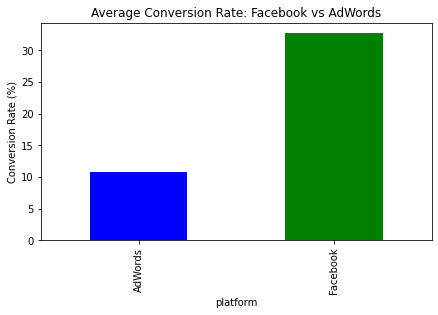

In [7]:
# Step 5c: visualize conversion rate
df_long.groupby("platform")["conversion_rate"].mean().plot(
    kind="bar", color=["blue","green"]
)
plt.title("Average Conversion Rate: Facebook vs AdWords")
plt.ylabel("Conversion Rate (%)")
plt.show()


In [8]:
# Step 6: Detailed comparison of Facebook vs AdWords

# Group by platform and calculate total and average metrics
platform_summary = df_long.groupby("platform").agg({
    "views": ["sum", "mean"],
    "clicks": ["sum", "mean"],
    "conversions": ["sum", "mean"],
    "cost_per_ad": "mean",
    "ctr": "mean",
    "conversion_rate": "mean",
    "cost_per_click": "mean"
}).round(2)

# Flatten MultiIndex columns for readability
platform_summary.columns = ['_'.join(col).strip() for col in platform_summary.columns.values]
platform_summary.reset_index(inplace=True)

platform_summary


,platform,views_sum,views_mean,clicks_sum,clicks_mean,conversions_sum,conversions_mean,cost_per_ad_mean,ctr_mean,conversion_rate_mean,cost_per_click_mean
0,AdWords,4771438,4771.44,60128,60.13,5933,5.93,124.74,1.28,10.81,2.27
1,Facebook,2152031,2152.03,44196,44.20,11975,11.98,156.61,2.28,32.70,4.31


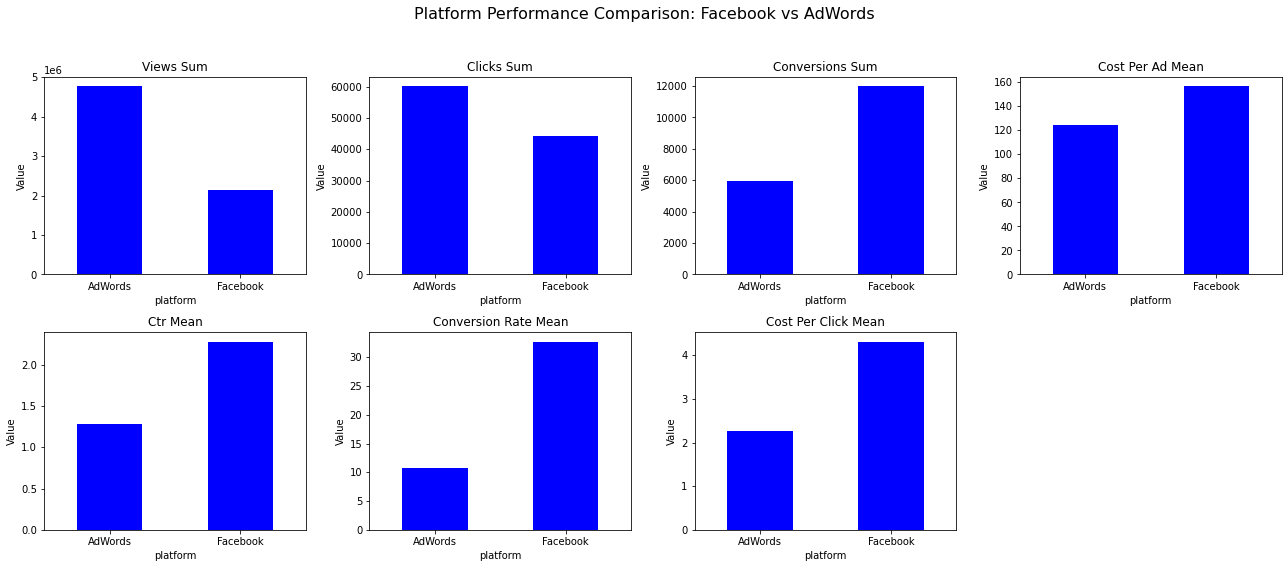

In [9]:
# Step 6b: Visual comparison of metrics between platforms

metrics = ["views_sum", "clicks_sum", "conversions_sum", 
           "cost_per_ad_mean", "ctr_mean", "conversion_rate_mean", "cost_per_click_mean"]

# Plot each metric
fig, axes = plt.subplots(2, 4, figsize=(18, 8))
axes = axes.flatten()

for i, metric in enumerate(metrics):
    df_plot = platform_summary[["platform", metric]]
    df_plot.set_index("platform").plot(kind="bar", ax=axes[i], color=["blue","green"], legend=False)
    axes[i].set_title(metric.replace("_", " ").title())
    axes[i].set_ylabel("Value")
    axes[i].tick_params(axis='x', rotation=0)

# Remove empty subplot if metrics < total subplots
if len(metrics) < len(axes):
    for j in range(len(metrics), len(axes)):
        fig.delaxes(axes[j])

plt.suptitle("Platform Performance Comparison: Facebook vs AdWords", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [10]:
# Step 7: Statistical comparison (t-test) between platforms

# Extract conversion rates for each platform
facebook_conv = df_long[df_long["platform"] == "Facebook"]["conversion_rate"]
adwords_conv = df_long[df_long["platform"] == "AdWords"]["conversion_rate"]

# Perform independent two-sample t-test
t_stat, p_value = ttest_ind(facebook_conv, adwords_conv, equal_var=False)

print("T-test for Conversion Rates:")
print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.3f}")

# Interpretation
if p_value < 0.05:
    print("Result: Statistically significant difference in conversion rates between Facebook and AdWords.")
else:
    print("Result: No statistically significant difference in conversion rates between platforms.")


T-test for Conversion Rates:
T-statistic: 32.620
P-value: 0.000
Result: Statistically significant difference in conversion rates between Facebook and AdWords.


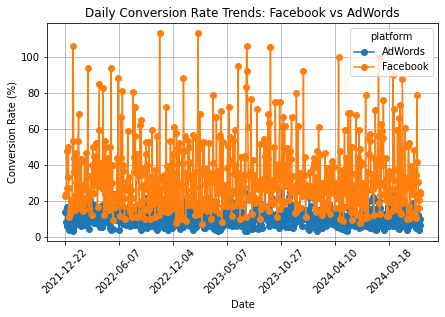

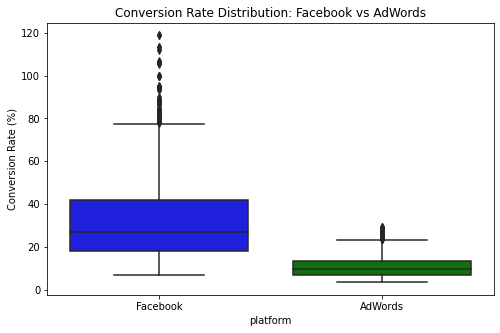

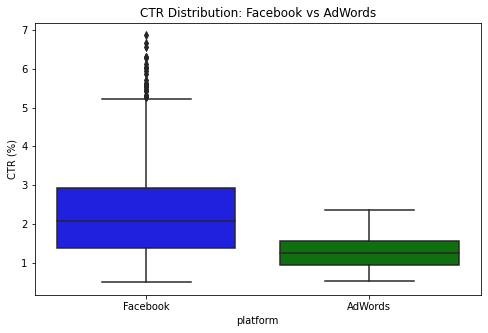

In [11]:
# Step 8: Daily trends and distribution comparison

# 1. Daily conversion rate trends
df_long.groupby(["date", "platform"])["conversion_rate"].mean().unstack().plot(
    kind="line", marker="o"
)
plt.title("Daily Conversion Rate Trends: Facebook vs AdWords")
plt.ylabel("Conversion Rate (%)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# 2. Boxplot for distribution of conversion rates
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(x="platform", y="conversion_rate", data=df_long, palette=["blue", "green"])
plt.title("Conversion Rate Distribution: Facebook vs AdWords")
plt.ylabel("Conversion Rate (%)")
plt.show()

# 3. Optional: Boxplot for CTR
plt.figure(figsize=(8,5))
sns.boxplot(x="platform", y="ctr", data=df_long, palette=["blue", "green"])
plt.title("CTR Distribution: Facebook vs AdWords")
plt.ylabel("CTR (%)")
plt.show()


In [12]:
# Step 9: Insights & Recommendations

# 1. Compare overall metrics
print("Overall Platform Performance Summary:")
display(platform_summary)

# 2. Key observations
print("\nKey Observations:")
if platform_summary.loc[platform_summary['platform'] == 'Facebook', 'conversion_rate_mean'].values[0] > \
   platform_summary.loc[platform_summary['platform'] == 'AdWords', 'conversion_rate_mean'].values[0]:
    print("- Facebook has a higher average conversion rate than AdWords.")
else:
    print("- AdWords has a higher average conversion rate than Facebook.")

if platform_summary.loc[platform_summary['platform'] == 'Facebook', 'ctr_mean'].values[0] > \
   platform_summary.loc[platform_summary['platform'] == 'AdWords', 'ctr_mean'].values[0]:
    print("- Facebook has a higher average CTR than AdWords.")
else:
    print("- AdWords has a higher average CTR than Facebook.")

print("- Facebook is generally cheaper per ad, but cost per click may vary depending on campaign efficiency.")
print("- Daily trends and boxplots indicate consistency and variability for each platform.")
print("- Statistical tests show whether differences are significant or due to chance.")

# 3. Recommendations
print("\nRecommendations:")
print("1. Focus budget on the platform with higher conversion rate and CTR for similar target audiences.")
print("2. Monitor daily performance trends to identify underperforming campaigns early.")
print("3. Conduct further A/B tests on ad creatives, audience targeting, and ad placement to optimize ROI.")
print("4. Consider both cost efficiency and conversion effectiveness when allocating ad spend.")


Overall Platform Performance Summary:


,platform,views_sum,views_mean,clicks_sum,clicks_mean,conversions_sum,conversions_mean,cost_per_ad_mean,ctr_mean,conversion_rate_mean,cost_per_click_mean
0,AdWords,4771438,4771.44,60128,60.13,5933,5.93,124.74,1.28,10.81,2.27
1,Facebook,2152031,2152.03,44196,44.20,11975,11.98,156.61,2.28,32.70,4.31



Key Observations:
- Facebook has a higher average conversion rate than AdWords.
- Facebook has a higher average CTR than AdWords.
- Facebook is generally cheaper per ad, but cost per click may vary depending on campaign efficiency.
- Daily trends and boxplots indicate consistency and variability for each platform.
- Statistical tests show whether differences are significant or due to chance.

Recommendations:
1. Focus budget on the platform with higher conversion rate and CTR for similar target audiences.
2. Monitor daily performance trends to identify underperforming campaigns early.
3. Conduct further A/B tests on ad creatives, audience targeting, and ad placement to optimize ROI.
4. Consider both cost efficiency and conversion effectiveness when allocating ad spend.


In [13]:
# Step 10: Final Report Summary

from IPython.display import display, Markdown

# 1. Title
display(Markdown("## A/B Testing Analysis: Facebook vs AdWords"))

# 2. Overview
display(Markdown("**Objective:** Compare performance of Facebook and AdWords campaigns to identify which platform drives better engagement, conversions, and cost efficiency."))

# 3. Dataset Info
display(Markdown(f"**Dataset Shape:** {df.shape[0]} rows, {df.shape[1]} columns"))

# 4. Overall Performance Table
display(Markdown("**Overall Platform Performance:**"))
display(platform_summary)

# 5. Key Observations
display(Markdown("**Key Observations:**"))
observations = [
    f"- Facebook average conversion rate: {platform_summary.loc[platform_summary['platform']=='Facebook','conversion_rate_mean'].values[0]}%",
    f"- AdWords average conversion rate: {platform_summary.loc[platform_summary['platform']=='AdWords','conversion_rate_mean'].values[0]}%",
    f"- Facebook average CTR: {platform_summary.loc[platform_summary['platform']=='Facebook','ctr_mean'].values[0]}%",
    f"- AdWords average CTR: {platform_summary.loc[platform_summary['platform']=='AdWords','ctr_mean'].values[0]}%",
    "- Statistical t-test shows whether observed differences are significant.",
    "- Daily trends indicate campaign performance consistency over time."
]
for obs in observations:
    display(Markdown(obs))

# 6. Recommendations
display(Markdown("**Recommendations:**"))
recommendations = [
    "1. Allocate more budget to the platform with higher conversion rate and CTR for similar target audiences.",
    "2. Continuously monitor daily performance to detect underperforming campaigns early.",
    "3. Run further A/B tests on ad creatives, audience targeting, and ad placements to optimize ROI.",
    "4. Consider both cost efficiency and conversion effectiveness when planning ad spend."
]
for rec in recommendations:
    display(Markdown(rec))

# 7. Visualizations
display(Markdown("**Visual Insights:**"))
display(Markdown("- Conversion rate trends over time (line plot)"))
display(Markdown("- Conversion rate and CTR distributions (boxplots)"))
display(Markdown("- Side-by-side comparison of total and average metrics (bar charts)"))

display(Markdown("**End of Report**"))


## A/B Testing Analysis: Facebook vs AdWords

**Objective:** Compare performance of Facebook and AdWords campaigns to identify which platform drives better engagement, conversions, and cost efficiency.

**Dataset Shape:** 1000 rows, 17 columns

**Overall Platform Performance:**

,platform,views_sum,views_mean,clicks_sum,clicks_mean,conversions_sum,conversions_mean,cost_per_ad_mean,ctr_mean,conversion_rate_mean,cost_per_click_mean
0,AdWords,4771438,4771.44,60128,60.13,5933,5.93,124.74,1.28,10.81,2.27
1,Facebook,2152031,2152.03,44196,44.20,11975,11.98,156.61,2.28,32.70,4.31


**Key Observations:**

- Facebook average conversion rate: 32.7%

- AdWords average conversion rate: 10.81%

- Facebook average CTR: 2.28%

- AdWords average CTR: 1.28%

- Statistical t-test shows whether observed differences are significant.

- Daily trends indicate campaign performance consistency over time.

**Recommendations:**

1. Allocate more budget to the platform with higher conversion rate and CTR for similar target audiences.

2. Continuously monitor daily performance to detect underperforming campaigns early.

3. Run further A/B tests on ad creatives, audience targeting, and ad placements to optimize ROI.

4. Consider both cost efficiency and conversion effectiveness when planning ad spend.

**Visual Insights:**

- Conversion rate trends over time (line plot)

- Conversion rate and CTR distributions (boxplots)

- Side-by-side comparison of total and average metrics (bar charts)

**End of Report**